# Delft 3D Verify 

This code will compare experimental data to the simulated data on Delft3D.

The data calculated with Delft3D using the 18m x 4m x 2m RGDGRID shown. The turbine used is a horizontal axis and has a swept area diameter of 0.7m.  Identical to the one used to collect the experimental data. The thrust coefficient is set to 0.72 and power coefficient to 0.45.The discretization is 0.2m at the outer corners of the flume and 0.1m around the turbine placed at (6,3) as shown in the figure:

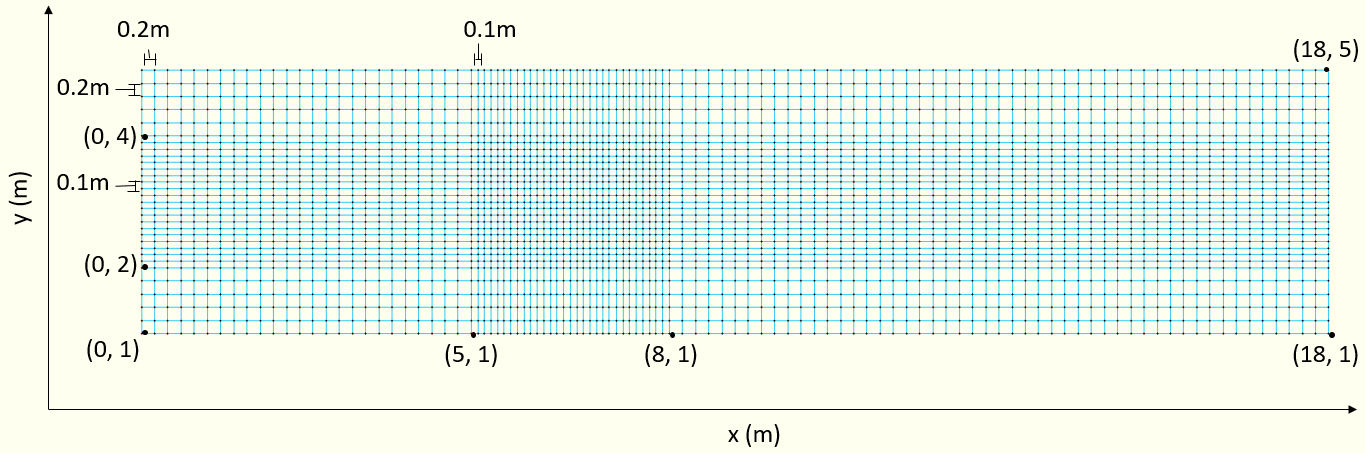


The experimental data was collected during a flume test as documented in this citation. The nondimensionalized data is documented in this paper: 
>   P. Mycek, B. Gaurier, G. Germain, G. Pinon, and E. Rivoalen, “Experimental study of the turbulence intensity effects on marine current turbines behaviour. Part I: One single turbine,” Renew. Energy, vol. 66, pp. 729–746, 2014, doi: 10.1016/j.renene.2013.12.036.  

Here is an example of re-dimensioning the experimental data. 
Nondimensionalized Centerline Data for a flume with 15% Turbulent Intensity at the inlet:

```
Velocity 15% inlet TI
   u*	y*	Downstream
0.51	0	1.2
0.595	0	2
0.788	0	3
0.862	0	4
0.911	0	5
0.913	0	6
0.927	0	7
0.953	0	8
0.965	0	9
0.954	0	10

Equations to dimensionalize: 
(u*)flow rate = raw velocity (ex:0.8 m/s)
y=0 at center of flume 
Downstream*diameter of turbine(ex:0.7)= meters downstream 
```

In [1]:
from os.path import abspath, dirname, join, normpath, relpath
from mhkit.river.io import d3d 
from math import isclose
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netCDF4
import math
plt.rcParams.update({'font.size': 15}) # Set fount size of plots title and labels 

## Experimental data

In [2]:
#Import Experimental data  3% TI 
datadir = normpath(join(relpath(join('data', 'river', 'flume_experiment'))))
filename= 'Mycek_03TI_vel.txt'
ucx_experiment_03= pd.read_csv(join(datadir,filename), delimiter="\t")
ucx_experiment_03['u']=ucx_experiment_03['u*']*0.8
ucx_experiment_centerline_03= ucx_experiment_03[ucx_experiment_03['y*'].values==0]
print(ucx_experiment_centerline_03)

#Import Experimental data  15% TI 
datadir = normpath(join(relpath(join('data', 'river', 'flume_experiment'))))
filename= 'Mycek_15TI_vel.txt'
ucx_experiment_15= pd.read_csv(join(datadir,filename), delimiter="\t")
ucx_experiment_15['u']=ucx_experiment_15['u*']*0.8
ucx_experiment_centerline_15= ucx_experiment_15[ucx_experiment_15['y*'].values==0]
print(ucx_experiment_centerline_15)

        u*   y*  Downstream       u
13   0.503  0.0         1.2  0.4024
40   0.504  0.0         2.0  0.4032
67   0.495  0.0         3.0  0.3960
94   0.482  0.0         4.0  0.3856
121  0.503  0.0         5.0  0.4024
148  0.556  0.0         6.0  0.4448
175  0.617  0.0         7.0  0.4936
202  0.685  0.0         8.0  0.5480
229  0.711  0.0         9.0  0.5688
256  0.763  0.0        10.0  0.6104
        u*   y*  Downstream       u
13   0.510  0.0         1.2  0.4080
40   0.595  0.0         2.0  0.4760
67   0.788  0.0         3.0  0.6304
94   0.862  0.0         4.0  0.6896
121  0.911  0.0         5.0  0.7288
148  0.913  0.0         6.0  0.7304
175  0.927  0.0         7.0  0.7416
202  0.953  0.0         8.0  0.7624
229  0.965  0.0         9.0  0.7720
256  0.954  0.0        10.0  0.7632


##  Simulated Data

In [3]:
# Downloading Data
datadir = normpath(join(relpath(join('data', 'river', 'd3d'))))
filename= 'Flume_verify_8m_map.nc' 
d3d_data = netCDF4.Dataset(join(datadir,filename)) 

In [4]:
# Getting variable data 
variable= 'ucx' 
var_data_df= d3d.get_all_data_points(d3d_data, variable, time_index=-1)
print(var_data_df)


          x    y         z       ucx   time
0       0.1  1.1  0.202957  0.574387  300.0
1       0.3  1.1  0.199863  0.553914  300.0
2       0.1  1.3  0.202957  0.574387  300.0
3       0.5  1.1  0.199627  0.559213  300.0
4       0.3  1.3  0.199863  0.553914  300.0
...     ...  ...       ...       ...    ...
15745  17.7  4.7  1.800354  0.990992  300.0
15746  17.5  4.9  1.800341  0.974414  300.0
15747  17.9  4.7  1.799983  1.003881  300.0
15748  17.7  4.9  1.800354  0.990857  300.0
15749  17.9  4.9  1.799984  1.003718  300.0

[15750 rows x 5 columns]


### Creating Points to interpolate onto 

In [5]:
xmin=var_data_df.x.max()
xmax=var_data_df.x.min()

ymin=var_data_df.y.max()
ymax=var_data_df.y.min()

zmin=var_data_df.z.max()
zmax=var_data_df.z.min()
print(np.unique(var_data_df.z))

# Creating one array and 2 points 
turbine_diameter= 0.7 #meters
turbine_x=6
x = np.array(ucx_experiment_centerline_15.Downstream*turbine_diameter+turbine_x)
y = np.mean([ymin,ymax])
z = np.mean([zmin,zmax])

# Creating an array of points  
cline_points = d3d.create_points(x, y, z)
cline_points

[0.19689641 0.19689641 0.19732871 ... 1.80038104 1.80041619 1.80045244]
0


,x,y,z
0,6.84,3.0,0.998674
1,7.40,3.0,0.998674
2,8.10,3.0,0.998674
3,8.80,3.0,0.998674
4,9.50,3.0,0.998674
5,10.20,3.0,0.998674
6,10.90,3.0,0.998674
7,11.60,3.0,0.998674
8,12.30,3.0,0.998674
9,13.00,3.0,0.998674


### Plotting Results

[0.5786394  0.58094159 0.59341234 0.62088592 0.64566385 0.66356491
 0.67760463 0.68901983 0.69870554 0.70703779]


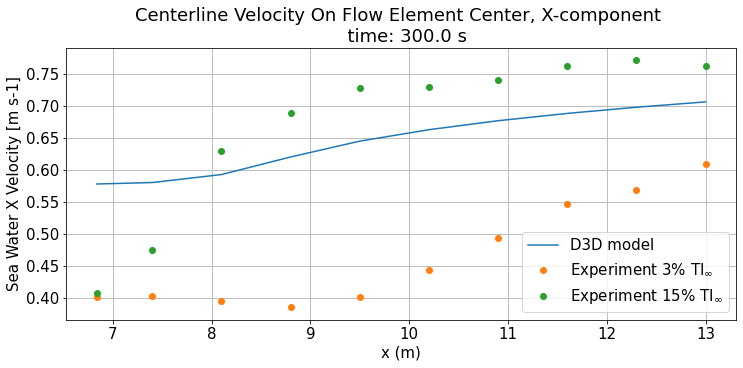

In [6]:
cline_variable = interp.griddata(var_data_df[['x','y','z']], 
                     var_data_df[variable],
                     cline_points[['x','y','z']]) 
print(cline_variable)
# Plotting
Type='Centerline'
plt.figure(figsize=(12,5))
Model= plt.plot(x, cline_variable, label="D3D model")
Exp=plt.plot(x, ucx_experiment_centerline_03.u,'o', label="Experiment 3% TI$_\infty$")
Exp=plt.plot(x, ucx_experiment_centerline_15.u,'o', label=f'Experiment 15% TI$_\infty$')
plt.grid()
plt.xlabel('x (m)')

y_name= f'{d3d_data.variables[variable].standard_name}'
y_label=' '.join([x.capitalize() for x in y_name.split('_')])
plt.ylabel(f'{y_label} [{d3d_data.variables[variable].units}]')

title_name= f'{d3d_data.variables[variable].long_name}'
title_label=' '.join([x.capitalize() for x in title_name.split(' ')])
plt.title(f'{Type} {title_label} \n  time: {var_data_df.time[1]} s')
plt.legend()

### Standard devation

In [7]:
 # Square deviations
deviations = (cline_variable - ucx_experiment_centerline_15.u)
print(deviations)
# Variance
MAPE= sum(deviations/ ucx_experiment_centerline_15.u)*100/10
print(MAPE)
MSE=sum((deviations/ucx_experiment_centerline_15.u)**2)/10
print(MSE)
max_error= 100*max(deviations/ ucx_experiment_centerline_15.u)
print(max_error)

13     0.170639
40     0.104942
67    -0.036988
94    -0.068714
121   -0.083136
148   -0.066835
175   -0.063995
202   -0.073380
229   -0.073294
256   -0.056162
Name: u, dtype: float64
-0.762661505148001
0.02894210434297087
41.823382243739225


[0, 1, 2]


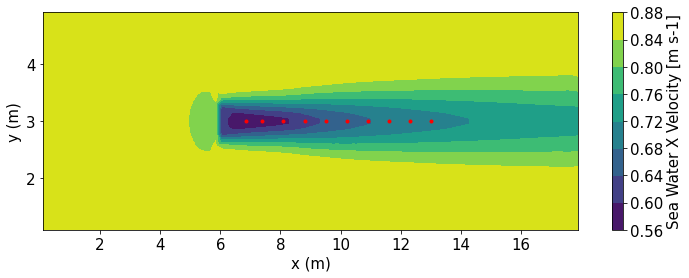

In [8]:
x_contour = np.linspace(xmin, xmax, num=100)
y_contour = np.linspace(ymin, ymax, num=40)
z_contour = np.mean([zmin,zmax])

contour_points = d3d.create_points(x_contour, y_contour, z_contour) 


contour_variable = interp.griddata(var_data_df[['x','y','z']], 
                                                     var_data_df[variable],
                                                     contour_points[['x','y','z']])


# Plotting 
Type= 'Contour'
plt.figure(figsize=(12,4))
contour_plot = plt.tricontourf(contour_points.x,contour_points.y,contour_variable)
                               #vmin=min_plot_v,vmax=max_plot_v,levels=np.linspace(min_plot_v,max_plot_v,10))
plt.plot(cline_points['x'], cline_points['y'], '.', color= 'red')

plt.xlabel('x (m)')
plt.ylabel('y (m)')
title_name= f'{d3d_data.variables[variable].long_name}'
title_label=' '.join([x.capitalize() for x in title_name.split(' ')])
#plt.title(f'{Type} {title_label} \n  Layer: {layer}')

cbar= plt.colorbar(contour_plot)
cbar_name= f'{d3d_data.variables[variable].standard_name}'
cbar_label=' '.join([x.capitalize() for x in cbar_name.split('_')])
cbar.set_label(f'{cbar_label} [{d3d_data.variables[variable].units}]')

0


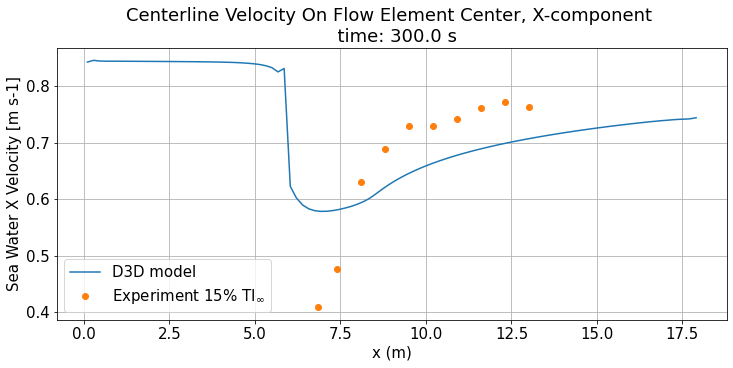

In [9]:
x_line = np.linspace(xmin, xmax, num=100)
y = np.mean([ymin, ymax])
z = np.mean([zmin,zmax])

contour_points = d3d.create_points(x_line, y, z) 

cline_variable = interp.griddata(var_data_df[['x','y','z']], 
                     var_data_df[variable],
                     contour_points[['x','y','z']]) 
# Plotting
Type='Centerline'
plt.figure(figsize=(12,5))
Model= plt.plot(x_line, cline_variable, label="D3D model")
Exp=plt.plot(x,ucx_experiment_centerline_15.u,'o', label=f'Experiment 15% TI$_\infty$')
plt.grid()
plt.xlabel('x (m)')

y_name= f'{d3d_data.variables[variable].standard_name}'
y_label=' '.join([x.capitalize() for x in y_name.split('_')])
plt.ylabel(f'{y_label} [{d3d_data.variables[variable].units}]')

title_name= f'{d3d_data.variables[variable].long_name}'
title_label=' '.join([x.capitalize() for x in title_name.split(' ')])
plt.title(f'{Type} {title_label} \n  time: {var_data_df.time[1]} s')
plt.legend()

## Turbulent Intensity 

In [10]:
x_contour = np.linspace(xmin, xmax, num=100)
y_contour = np.linspace(ymin, ymax, num=40)
z_contour = np.mean([zmin,zmax])

contour_points = d3d.create_points(x_contour, y_contour, z_contour) 

TI= d3d.turbulent_intensity(d3d_data, points= contour_points ,intermediate_values = True) 
TI

[0, 1, 2]
points provided


,x,y,z,turkin1,ucx,ucy,ucz,turbulent_intensity
0,17.900000,4.9,0.998674,0.001737,0.861037,1.306241e-04,-0.024032,0.039506
1,17.720202,4.9,0.998674,0.001692,0.856974,1.123776e-04,0.115079,0.038842
2,17.540404,4.9,0.998674,0.001626,0.854515,1.116905e-04,0.013497,0.038522
3,17.360606,4.9,0.998674,0.001547,0.855307,9.987162e-05,-0.012701,0.037540
4,17.180808,4.9,0.998674,0.001522,0.855483,8.246612e-05,-0.001460,0.037240
...,...,...,...,...,...,...,...,...
3995,0.819192,1.1,0.998674,0.001112,0.844479,-4.454922e-07,-0.000135,0.032236
3996,0.639394,1.1,0.998674,0.001106,0.844512,-3.194806e-07,0.001603,0.032157
3997,0.459596,1.1,0.998674,0.001111,0.844795,-2.197608e-07,0.004556,0.032217
3998,0.279798,1.1,0.998674,0.001089,0.845970,-1.346329e-07,-0.011867,0.031853


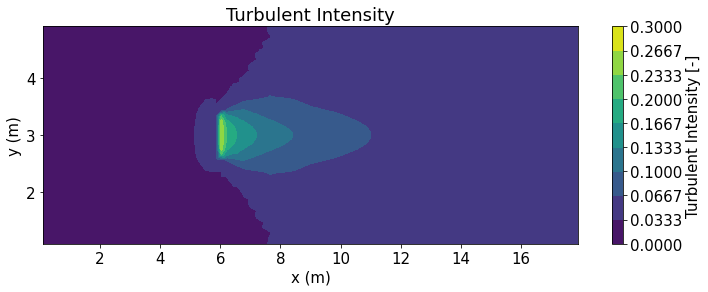

In [11]:
# Creating new plot limits 
max_plot_v= 0.3
min_plot_v=0

# Plotting 
plt.figure(figsize=(12,4))
contour_plot = plt.tricontourf(TI.x, TI.y, TI.turbulent_intensity,
                               vmin=min_plot_v, vmax=max_plot_v,levels=np.linspace(min_plot_v,max_plot_v,10))
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Turbulent Intensity')
cbar= plt.colorbar(contour_plot)
cbar.set_label('Turbulent Intensity [-]')

In [12]:
#Turbulent Intensity Center Line Plot 
#Import Experimental data  3% TI 
datadir = normpath(join(relpath(join('data', 'river', 'flume_experiment'))))
filename= 'Mycek_03TI_TI.txt'
TI_experiment_03= pd.read_csv(join(datadir,filename), delimiter="\t")
TI_experiment_centerline_03= TI_experiment_03[TI_experiment_03['y*'].values==0]
print(ucx_experiment_centerline_03)

#Import Experimental data  15% TI 
datadir = normpath(join(relpath(join('data', 'river', 'flume_experiment'))))
filename= 'Mycek_15TI_TI.txt'
TI_experiment_15= pd.read_csv(join(datadir,filename), delimiter="\t")
TI_experiment_centerline_15= TI_experiment_15[TI_experiment_15['y*'].values==0]
print(ucx_experiment_centerline_15)


        u*   y*  Downstream       u
13   0.503  0.0         1.2  0.4024
40   0.504  0.0         2.0  0.4032
67   0.495  0.0         3.0  0.3960
94   0.482  0.0         4.0  0.3856
121  0.503  0.0         5.0  0.4024
148  0.556  0.0         6.0  0.4448
175  0.617  0.0         7.0  0.4936
202  0.685  0.0         8.0  0.5480
229  0.711  0.0         9.0  0.5688
256  0.763  0.0        10.0  0.6104
        u*   y*  Downstream       u
13   0.510  0.0         1.2  0.4080
40   0.595  0.0         2.0  0.4760
67   0.788  0.0         3.0  0.6304
94   0.862  0.0         4.0  0.6896
121  0.911  0.0         5.0  0.7288
148  0.913  0.0         6.0  0.7304
175  0.927  0.0         7.0  0.7416
202  0.953  0.0         8.0  0.7624
229  0.965  0.0         9.0  0.7720
256  0.954  0.0        10.0  0.7632


In [13]:
x_centerline = np.linspace(xmin, xmax, num=100)
y_centerline = np.mean([ymin,ymax])
z_centerline = np.mean([zmin,zmax])

centerline_points = d3d.create_points(x_centerline, y_centerline, z_centerline) 

TI= d3d.turbulent_intensity(d3d_data, points= centerline_points ,intermediate_values = True) 
TI

0
points provided


,x,y,z,turkin1,ucx,ucy,ucz,turbulent_intensity
0,17.900000,3.0,0.998674,0.001715,0.744251,-1.278622e-06,-0.026978,0.045407
1,17.720202,3.0,0.998674,0.001748,0.742329,-7.351947e-06,0.106147,0.045518
2,17.540404,3.0,0.998674,0.001698,0.741740,4.062199e-05,0.012451,0.045357
3,17.360606,3.0,0.998674,0.001689,0.741322,-1.951640e-05,-0.007929,0.045262
4,17.180808,3.0,0.998674,0.001704,0.740500,-1.569433e-05,0.002664,0.045510
...,...,...,...,...,...,...,...,...
95,0.819192,3.0,0.998674,0.001112,0.844476,3.422760e-08,-0.000135,0.032239
96,0.639394,3.0,0.998674,0.001108,0.844510,1.924747e-08,0.001603,0.032176
97,0.459596,3.0,0.998674,0.001114,0.844794,1.059120e-08,0.004556,0.032265
98,0.279798,3.0,0.998674,0.001097,0.845970,-4.434634e-09,-0.011867,0.031961


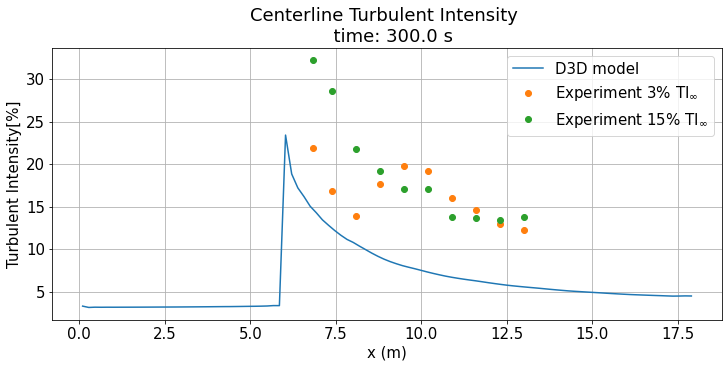

In [14]:

# Plotting
Type='Centerline'
plt.figure(figsize=(12,5))
Model= plt.plot(TI.x, TI.turbulent_intensity*100, label="D3D model")
Exp=plt.plot(x,TI_experiment_centerline_03.TI,'o', label=f'Experiment 3% TI$_\infty$')
Exp=plt.plot(x,TI_experiment_centerline_15.TI,'o', label=f'Experiment 15% TI$_\infty$')
plt.grid()
plt.xlabel('x (m)')

plt.ylabel('Turbulent Intensity[%]')

title_name= f'{d3d_data.variables[variable].long_name}'
title_label=' '.join([x.capitalize() for x in title_name.split(' ')])
plt.title(f'{Type} Turbulent Intensity \n  time: {var_data_df.time[1]} s')
plt.legend()

## Cross Section Contours

[0, 1, 2]
points provided


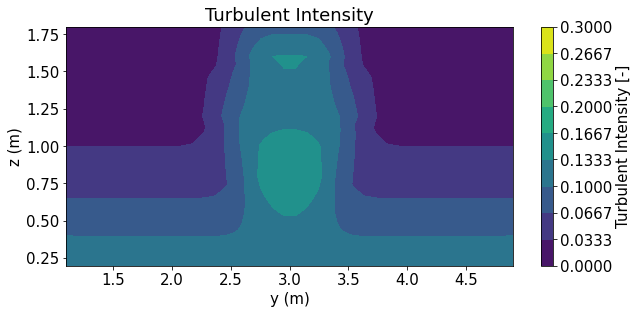

In [15]:
turbine_x_loc= 6 
turbine_diameter= 0.7
N=1
x_sample = turbine_x_loc+N*turbine_diameter
y_samples = np.linspace(ymin, ymax, num=40)
z_samples = np.linspace(zmin,zmax, num=256)

sample_points = d3d.create_points(x_sample, y_samples, z_samples) 

TI= d3d.turbulent_intensity(d3d_data, points = sample_points ,intermediate_values = True) 

plt.figure(figsize=(10,4.4))
contour_plot = plt.tricontourf(TI.y, TI.z, TI.turbulent_intensity,
                               vmin=min_plot_v, vmax=max_plot_v,levels=np.linspace(min_plot_v,max_plot_v,10))
plt.xlabel('y (m)')
plt.ylabel('z (m)')
plt.title('Turbulent Intensity')
cbar= plt.colorbar(contour_plot)
cbar.set_label('Turbulent Intensity [-]')


[0, 1, 2]
points provided


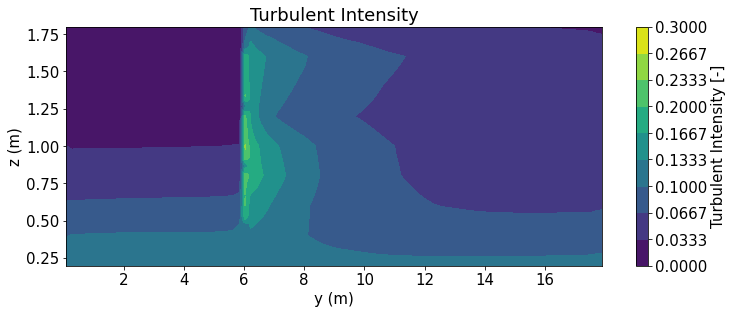

In [16]:
turbine_x_loc= 6 
turbine_diameter= 0.7
N=1
x_sample = np.linspace(xmin, xmax, num=100)
y_samples = np.mean([ymin,ymax])
z_samples = np.linspace(zmin,zmax, num=256)

sample_points = d3d.create_points(x_sample, y_samples, z_samples) 

TI= d3d.turbulent_intensity(d3d_data, points = sample_points ,intermediate_values = True) 

plt.figure(figsize=(12,4.4))
contour_plot = plt.tricontourf(TI.x, TI.z, TI.turbulent_intensity,
                               vmin=min_plot_v, vmax=max_plot_v,levels=np.linspace(min_plot_v,max_plot_v,10))
plt.xlabel('y (m)')
plt.ylabel('z (m)')
plt.title('Turbulent Intensity')
cbar= plt.colorbar(contour_plot)
cbar.set_label('Turbulent Intensity [-]')